Machine learning capstone project - fx spot prediction

The goal is to create features that can help predict the bid price, using a lookback period of a few minutes.

Try to include the bid offer spread - from the benchmark model it seems volume is not an important feature so it is not a problem that i dont have this data point.

I took inspiration from : https://www.kaggle.com/kimy07/eurusd-15-minute-interval-price-prediction/notebook

Introduction
This notebook trains a LSTM model that predicts the bid price of EURUSD 15 minutes in the future by looking at last five hours of data. While there is no requirement for the input to be contiguous, it's been empirically observed that having the contiguous input does improve the accuracy of the model. I suspect that having day of the week and hour of the day as the features mitigates some of the seasonality and contiguousness problems.

Disclaimer: This exercise has been carried out using a small sample data which only contains 14880 samples (2015-12-29 00:00:00 to 2016-05-31 23:45:00) and lacks ASK prices. Which restricts the ability for the model to approach a better accuracy.

I will use 1 year of data, from 1Jan16 to 1Jan17, also in 15 minute intervals, but with tick data features.

Improvements

To tune the model further, I would recommend having at least 5 years worth of data, have ASK price (so that you can compute the spread), and increasing the epoch to 3000.
Adding more cross-axial features. Such as spread.
If you are looking into classification approach (PASS, BUY, SELL), consider adding some technical indicators that is more sensitive to more recent data.
Consider adding non-numerical data, e.g. news, Tweets. The catch is that you have to get the data under one minute for trading, otherwise the news will be reflected before you even make a trade. If anybody knows how to get the news streamed really fast, please let me know.

Credits : Dave Y. Kim, Mahmoud Elsaftawy,

To run on EC2:
Enter the repo directory: cd aind2-cnn
Activate the new environment: source activate aind2
Start Jupyter: jupyter notebook --ip=0.0.0.0 --no-browser
Find this line in output and copy url to browser: 
Copy/paste this URL into your browser when you connect for the first time to login with a token: 
http://0.0.0.0:8888/?token=3156e...

change the 0.0.0.0 with EC2 IP.

you should see the checked out repository

In [2]:
import pandas as pd, numpy as np
import pypyodbc
import io, datetime
import matplotlib.colors as colors, matplotlib.cm as cm, pylab, matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from subprocess import check_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
import pypyodbc
display(HTML("""<script>
  
    $('.ctb_hideshow').toggle();
    
    </script>
 """))

In [5]:
#kaggle dates: 2015-12-29 00:00:00 to 2016-05-31 23:45:00
min_date = "29Dec15"
max_date = "31May16"

In [10]:
simname = "mine"

In [20]:
print(min_date)
print(max_date)

29Dec15
31May16


In [4]:

strConnDef = "DRIVER={ODBC Driver 13 for SQL Server};SERVER=localhost,1433;DATABASE=kai_dw;uid=kai_ta;pwd=tenpen12"
def getQueryRaw(strQuery, params=None, strConn=strConnDef, commitOn=None):

    if commitOn is None:
        commitOn = False

    if params is None:
        params = []

    pypyodbc.lowercase = False
    conn = pypyodbc.connect(strConn)
    cursor = conn.cursor()
    cursor.execute(strQuery, params)

    if commitOn:
        conn.commit()
        return "sql insert was successful.", "sql insert was successful."
    try:
        rows = cursor.fetchall()
        #print("rows", rows)
        # print("PARAMS:", params)
        description = cursor.description
        conn.close()
        return rows, description
    except:
        # print("THE QUERY: " + strQuery) TODO: add query
        conn.close()
        raise ValueError("There was an error fetching a sql query. Make sure the index exists for your selected dates. THE PARAMS: ", params)




def getQueryDataframe(strQuery, params=None, strConn=strConnDef, columnMustAlwaysExist=None, commitOn=None):

    rows, cursorDescription = getQueryRaw(strQuery, params, strConn, commitOn)
    if commitOn:
        return "sql insert was successful."

    if len(rows) == 0:
        print("No rows were returned.")
        print("THE PARAMS: ", params)
        print("THE QUERY: " + strQuery)
        print("Rows length is zero. No records returned")

        if columnMustAlwaysExist is None:
            columnMustAlwaysExist = "Empty"

        columns = ["Information", columnMustAlwaysExist]
        rows = [
            ["No results were returned.", "There is no data."]
            , ["No results were returned.", "There is no data."]
        ]

    else:
        # bytes conversion needed because of the linux pypyodbc bug
        columns = [column[0].decode("cp1252") if type(column[0]) == bytes else column[0] for column in
                   cursorDescription]

    results = pd.DataFrame(data=rows, columns=columns)


    return results


In [21]:
# create 15 minute data - this fills the 15 minutes table
str_query = open("get_data.sql", "r").read() # returns prepared data
str_query = str_query.replace("/*", "").replace("*/", "")

df = getQueryDataframe(str_query, [min_date, max_date])

In [5]:
# dates only have an effect if a subset of dates is needed.
str_query = open("get_data_1y.sql", "r").read() # returns prepared data
str_query = str_query.replace("/*", "").replace("*/", "")
#print(str_query)
df = getQueryDataframe(str_query, [min_date, max_date])
df.head()

,year,month,day,hour,weekday,15_min,datestamp,high_bid,low_bid,avg_bo_spread,nb_ticks,open_bid,close_bid,last_10_tick_avg_bid_return,last_10_tick_avg_bo_spread
0,2016,1,3,17,1,0,2016-01-03 17:00:00,1.08723,1.08661,0.000165,142,1.08701,1.08664,-2.760660e-06,0.000139
1,2016,1,3,17,1,15,2016-01-03 17:15:00,1.08714,1.08662,0.000149,80,1.08666,1.08674,1.104220e-05,0.000154
2,2016,1,3,17,1,30,2016-01-03 17:30:00,1.08699,1.08671,0.000141,109,1.08674,1.08674,-9.201579e-07,0.000153
3,2016,1,3,17,1,45,2016-01-03 17:45:00,1.08687,1.08655,0.000102,93,1.08674,1.08662,7.362178e-06,0.000094
4,2016,1,3,18,1,0,2016-01-03 18:00:00,1.08665,1.08523,0.000113,459,1.08662,1.08574,1.013142e-05,0.000093


In [6]:
df.set_index('datestamp', inplace=True)
print("min date", min(df.index))
print("max date", max(df.index))

min date 2016-01-03 17:00:00
max date 2016-05-30 23:45:00


In [24]:
df.to_csv("eurusd_features.csv")

In [2]:
df_res = pd.read_csv("data/eurusd_features.csv")
df_res.set_index('date', inplace=True)

In [6]:
# load kaggle reference dataset for comparison
df_kaggle = pd.read_csv('data/bm_kaggle/EURUSD_15m_BID_sample.csv')
#df_kaggle = pd.read_csv('data/bm_kaggle/EURUSD_15m_BID_01.01.2010-31.12.2016.csv')

# Rename bid OHLC columns
df_kaggle.rename(columns={'Time' : 'date', 'Open' : 'open_bid', 'Close' : 'close_bid', 
                   'High' : 'high_bid', 'Low' : 'low_bid', 'Volume' : 'volume'}, inplace=True)
df_kaggle['date'] = pd.to_datetime(df_kaggle['date'], infer_datetime_format=True)
df_kaggle.set_index('date', inplace=True)
df_kaggle = df_kaggle.astype(float)

simname = "bm_kaggle"

df = df_kaggle
print("min date", min(df.index))
print("max date", max(df.index))

min date 2015-12-29 00:00:00
max date 2016-05-31 23:45:00


In [7]:
# to include seasonality as a feature
if simname == "bm_kaggle":
    df['hour'] = df.index.hour
    df['day']  = df.index.weekday
    df['week'] = df.index.week
    df['month'] = df.index.month

    df['momentum']  = df['volume'] * (df['open_bid'] - df['close_bid'])
df['avg_price'] = (df['low_bid'] + df['high_bid'])/2
df['range']     = df['high_bid'] - df['low_bid']
df['ohlc_price'] = (df['low_bid'] + df['high_bid'] + df['open_bid'] + df['close_bid'])/4
df['oc_diff']    = df['open_bid'] - df['close_bid']
#df['bo_spread'] = df.ask - df.bid
df['period_return'] = df.close_bid / df.open_bid

c:\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


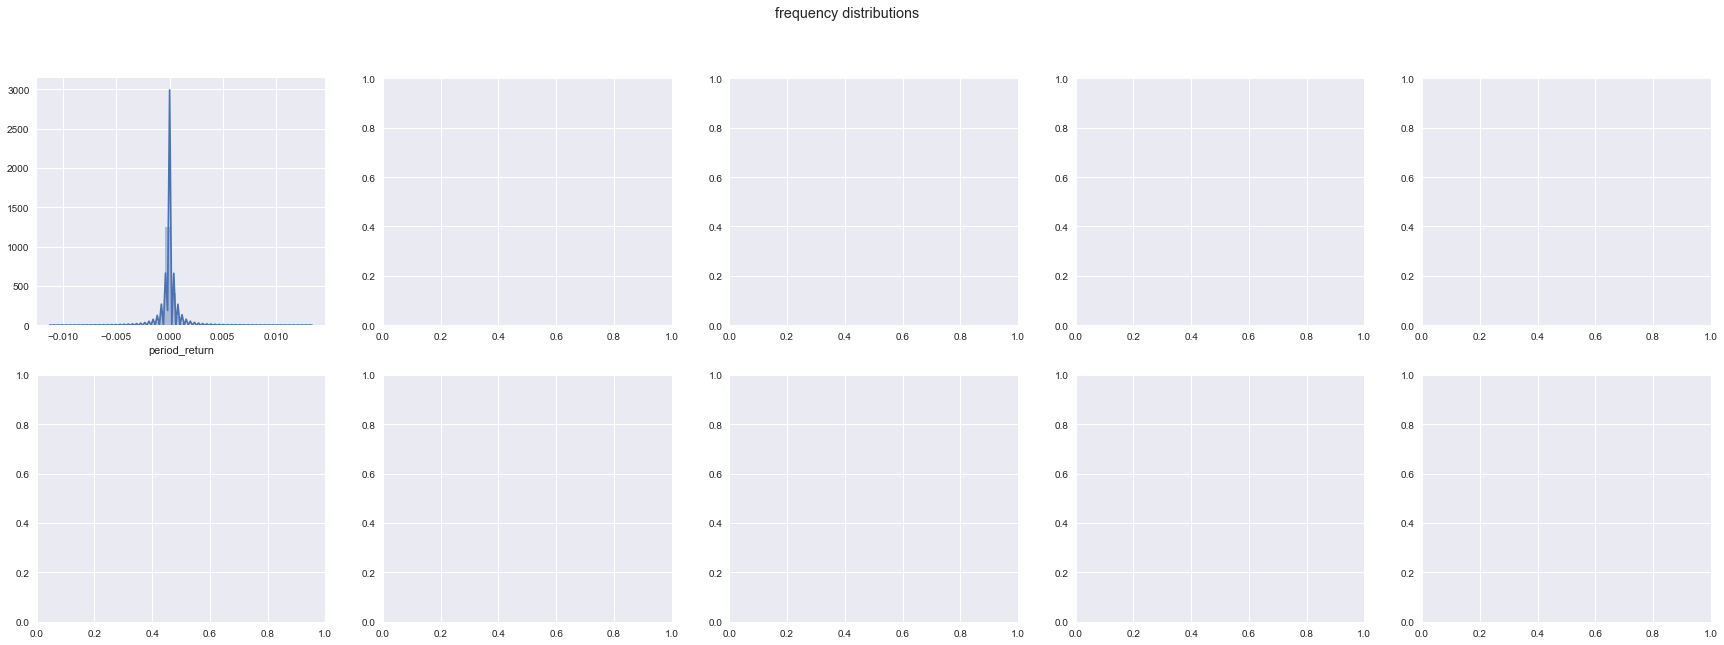

Nb Rows:  14880


In [8]:
# create ohlc prices, analyse distribution, think about feature transformation and de-trending

fig, axarr = plt.subplots(2, 5, figsize=(30,10)) #1 row, 2 cols, x, y
#plt.figure(figsize=(20, 4))
i_row, i_col = 0,0
fig.suptitle("frequency distributions")


sns.distplot(df.period_return-1, ax=axarr[i_row, i_col])
#axarr[0, 0].set_title('Axis [0,0] Subtitle')

# i_col += 1
# sns.distplot(df.bo_spread, ax=axarr[i_row, i_col])


if simname != "bm_kaggle":
    i_col += 1
    sns.distplot(df.avg_bo_spread, ax=axarr[i_row, i_col])

    x_axis_col = "ohlc_price"
    y_axis_col = "avg_bo_spread"
    i_col += 1
    norm = colors.Normalize(df[x_axis_col].values.min(), df[x_axis_col].values.max())
    color = cm.viridis(norm(df[x_axis_col].values))
    axarr[i_row, i_col].scatter(df[x_axis_col].values, df[y_axis_col].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
    axarr[i_row, i_col].set_xlabel(x_axis_col)



    x_axis_col = "period_return"
    y_axis_col = "avg_bo_spread"
    i_col += 1
    norm = colors.Normalize(df[x_axis_col].values.min(), df[x_axis_col].values.max())
    color = cm.viridis(norm(df[x_axis_col].values))
    axarr[i_row, i_col].scatter(df[x_axis_col].values, df[y_axis_col].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
    axarr[i_row, i_col].set_xlabel(x_axis_col)


    i_row, i_col = 1, 0 # move down one row

    x_axis_col = "hour"
    y_axis_col = "avg_bo_spread"
    norm = colors.Normalize(df[x_axis_col].values.min(), df[x_axis_col].values.max())
    color = cm.viridis(norm(df[x_axis_col].values))
    axarr[i_row, i_col].scatter(df[x_axis_col].values, df[y_axis_col].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
    axarr[i_row, i_col].set_xlabel(x_axis_col)


    x_axis_col = "hour"
    y_axis_col = "nb_ticks"
    i_col += 1
    norm = colors.Normalize(df[x_axis_col].values.min(), df[x_axis_col].values.max())
    color = cm.viridis(norm(df[x_axis_col].values))
    axarr[i_row, i_col].scatter(df[x_axis_col].values, df[y_axis_col].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
    axarr[i_row, i_col].set_xlabel(x_axis_col)

    x_axis_col = "day"
    y_axis_col = "nb_ticks"
    i_col += 1
    norm = colors.Normalize(df[x_axis_col].values.min(), df[x_axis_col].values.max())
    color = cm.viridis(norm(df[x_axis_col].values))
    axarr[i_row, i_col].scatter(df[x_axis_col].values, df[y_axis_col].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
    axarr[i_row, i_col].set_xlabel(x_axis_col)


#plt.tight_layout() # reduce overlap
plt.show()

print("Nb Rows: ", df.high_bid.count())

In [95]:
# all at once
#sns.pairplot(df, hue="bo_spread")

KeyboardInterrupt: 

In [164]:
import dill as pickle
with open(simname+'_eurusd_features.pkl', 'wb') as file:
    pickle.dump(df, file)

In [31]:
# Add PCA as a feature instead of for reducing the dimensionality. This improves the accuracy a bit.
from sklearn.decomposition import PCA

dataset = df.copy().values.astype('float32')
pca_features = df.columns.tolist()

pca = PCA(n_components=1)
df['pca'] = pca.fit_transform(dataset)

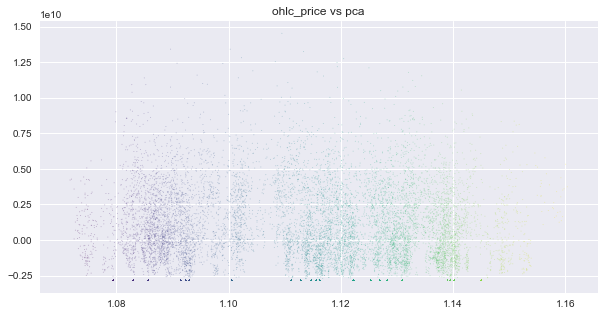

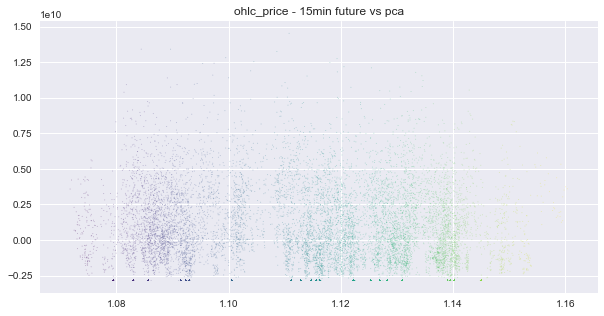

In [32]:

plt.figure(figsize=(10,5))
norm = colors.Normalize(df['ohlc_price'].values.min(), df['ohlc_price'].values.max())
color = cm.viridis(norm(df['ohlc_price'].values))
plt.scatter(df['ohlc_price'].values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('ohlc_price vs pca')
plt.show()

if simname != "bm_kaggle":

    plt.figure(figsize=(10,5))
    norm = colors.Normalize(df['avg_bo_spread'].values.min(), df['avg_bo_spread'].values.max())
    color = cm.viridis(norm(df['avg_bo_spread'].values))
    plt.scatter(df['avg_bo_spread'].values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
    plt.title('avg_bo_spread vs pca')
    plt.show()


    plt.figure(figsize=(10,5))
    norm = colors.Normalize(df['avg_bo_spread'].values.min(), df['avg_bo_spread'].values.max())
    color = cm.viridis(norm(df['avg_bo_spread'].values))
    plt.scatter(df['avg_bo_spread'].values, df['ohlc_price'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
    plt.title('avg_bo_spread vs ohlc_price')
    plt.show()


    plt.figure(figsize=(10,5))
    norm = colors.Normalize(df['avg_bo_spread'].values.min(), df['avg_bo_spread'].values.max())
    color = cm.viridis(norm(df['avg_bo_spread'].values))
    plt.scatter(df['avg_bo_spread'].values, df['period_return'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
    plt.title('avg_bo_spread vs period_return')
    plt.show()
    
    plt.figure(figsize=(10,5))
    norm = colors.Normalize(df['avg_bo_spread'].values.min(), df['avg_bo_spread'].values.max())
    color = cm.viridis(norm(df['avg_bo_spread'].values))
    plt.scatter(df['avg_bo_spread'].values, df['period_return'].shift().values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
    plt.title('avg_bo_spread vs period_return shift')
    plt.show()
    
  

plt.figure(figsize=(10,5))
norm = colors.Normalize(df['ohlc_price'].values.min(), df['ohlc_price'].values.max())
color = cm.viridis(norm(df['ohlc_price'].values))
plt.scatter(df['ohlc_price'].shift().values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('ohlc_price - 15min future vs pca')
plt.show()


In [33]:
# this creates a training dataset for the model
def create_dataset(dataset, look_back_rows=20):
    dataX, dataY = [], [] # for training
    # it creates for each row a 20 row lookback dataset
    # this expands the data by 20!
    for i in range(len(dataset)-look_back_rows-1): # 
        a = dataset[i:(i+look_back_rows)] # from example 1 to 21
        dataX.append(a)
        dataY.append(dataset[i + look_back_rows]) #get example 1+20, so the next point that is to be forecasted
    return np.array(dataX), np.array(dataY)

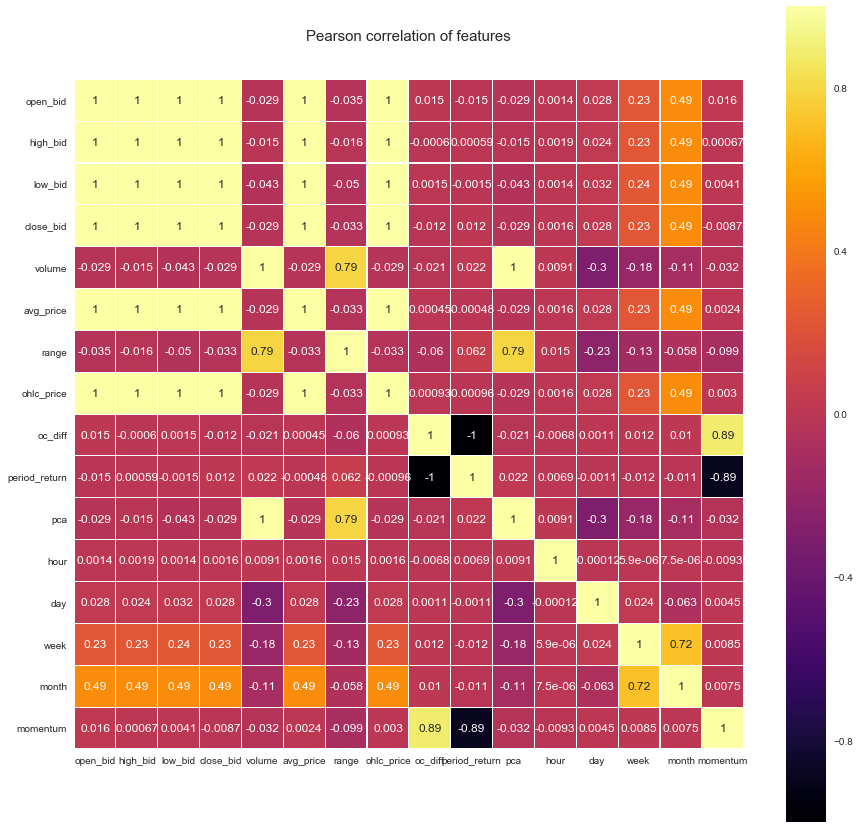

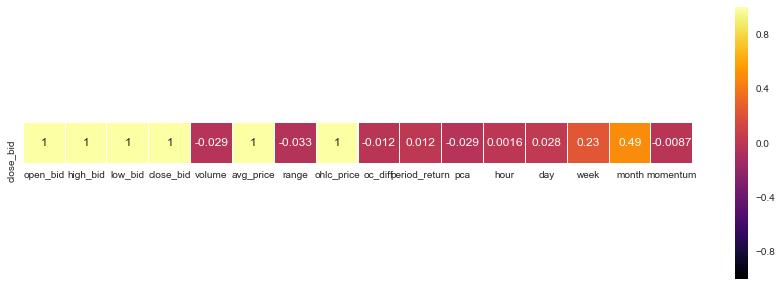

In [34]:
# check feature correlation, to see what correlates with the close price
colormap = plt.cm.inferno
plt.figure(figsize=(15,15))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

plt.figure(figsize=(15,5))
corr = df.corr()
sns.heatmap(corr[corr.index == 'close_bid'], linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

In [35]:
# create random forest regressor - random decision trees, like weak learner, ada boost
from sklearn.ensemble import RandomForestRegressor

# Scale and create datasets
target_index = df.columns.tolist().index('close_bid') # predict this, should it be return?
dataset = df.values.astype('float32') # so regressor can use it

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset) # scale features to between 0 and 1 for faster convergence

# Set look_back to 100 which is 100 ticks
# look back is 1 period, to check which features predict best a 1 period return
look_back_rows = 1 # to work with more than one, use alternative reshape
X, y = create_dataset(dataset, look_back_rows=look_back_rows) # look back only 1 row
y = y[:,target_index]
#TODO:X = np.reshape(X, (X.shape[0], X.shape[2]* look_back_rows)) # to get back rows and columns
X = np.reshape(X, (X.shape[0], X.shape[2])) # to get back rows and columns
# extend extra rows into columns, as all the prices during lookback periodd should be used as features.

In [15]:
X.shape
#y.shape
#X[0].shape
#X.shape[2]
#np.reshape(X, (X.shape[0]*10, X.shape[2]))

(14878, 11)

In [36]:
# fit model
forest = RandomForestRegressor(n_estimators = 100)
forest = forest.fit(X, y)

Feature ranking:
0. close_bid 3 (0.816391)
1. ohlc_price 7 (0.067108)
2. high_bid 1 (0.064573)
3. avg_price 5 (0.050164)
4. low_bid 2 (0.001339)
5. open_bid 0 (0.000077)
6. range 6 (0.000056)
7. momentum 15 (0.000053)
8. volume 4 (0.000046)
9. pca 10 (0.000045)
10. hour 11 (0.000038)
11. oc_diff 8 (0.000028)
12. period_return 9 (0.000028)
13. week 13 (0.000023)
14. day 12 (0.000023)


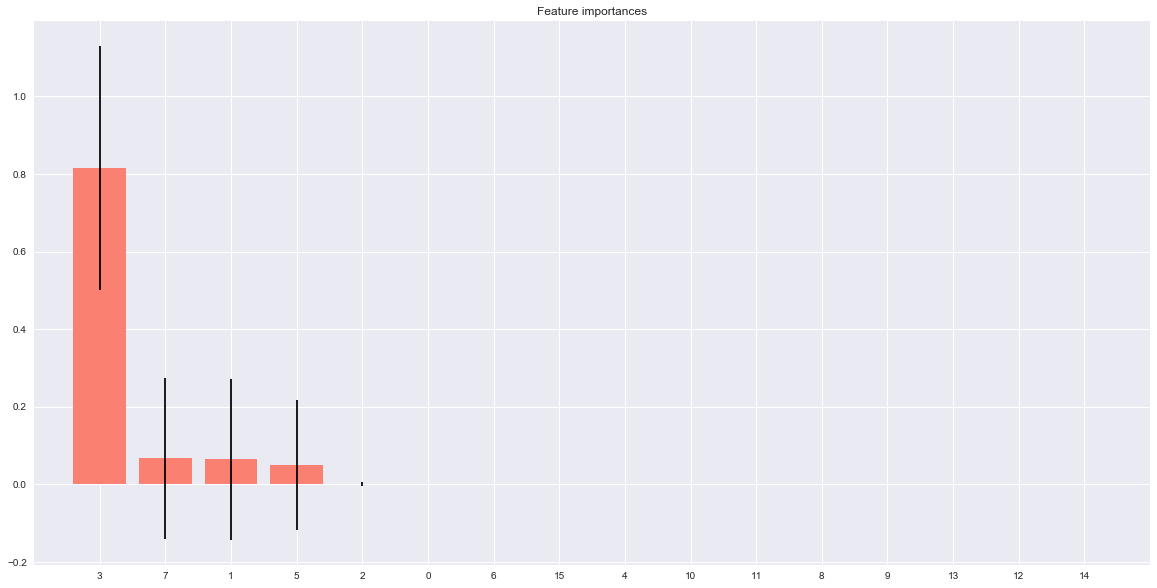

In [37]:
# find feature with best explanatory power to predict close price
importances = forest.feature_importances_
std = np.std([forest.feature_importances_ for forest in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1] # get indices for importances
#print(indices)

column_list = df.columns.tolist()
#print(column_list)
print("Feature ranking:")
for f in range(X.shape[1]-1):
    print("%d. %s %d (%f)" % (f, column_list[indices[f]], indices[f], importances[indices[f]]))

    
# Plot the feature importances coming from the forest of decision trees and their standard deviation
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="salmon", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [24]:
#df.info()

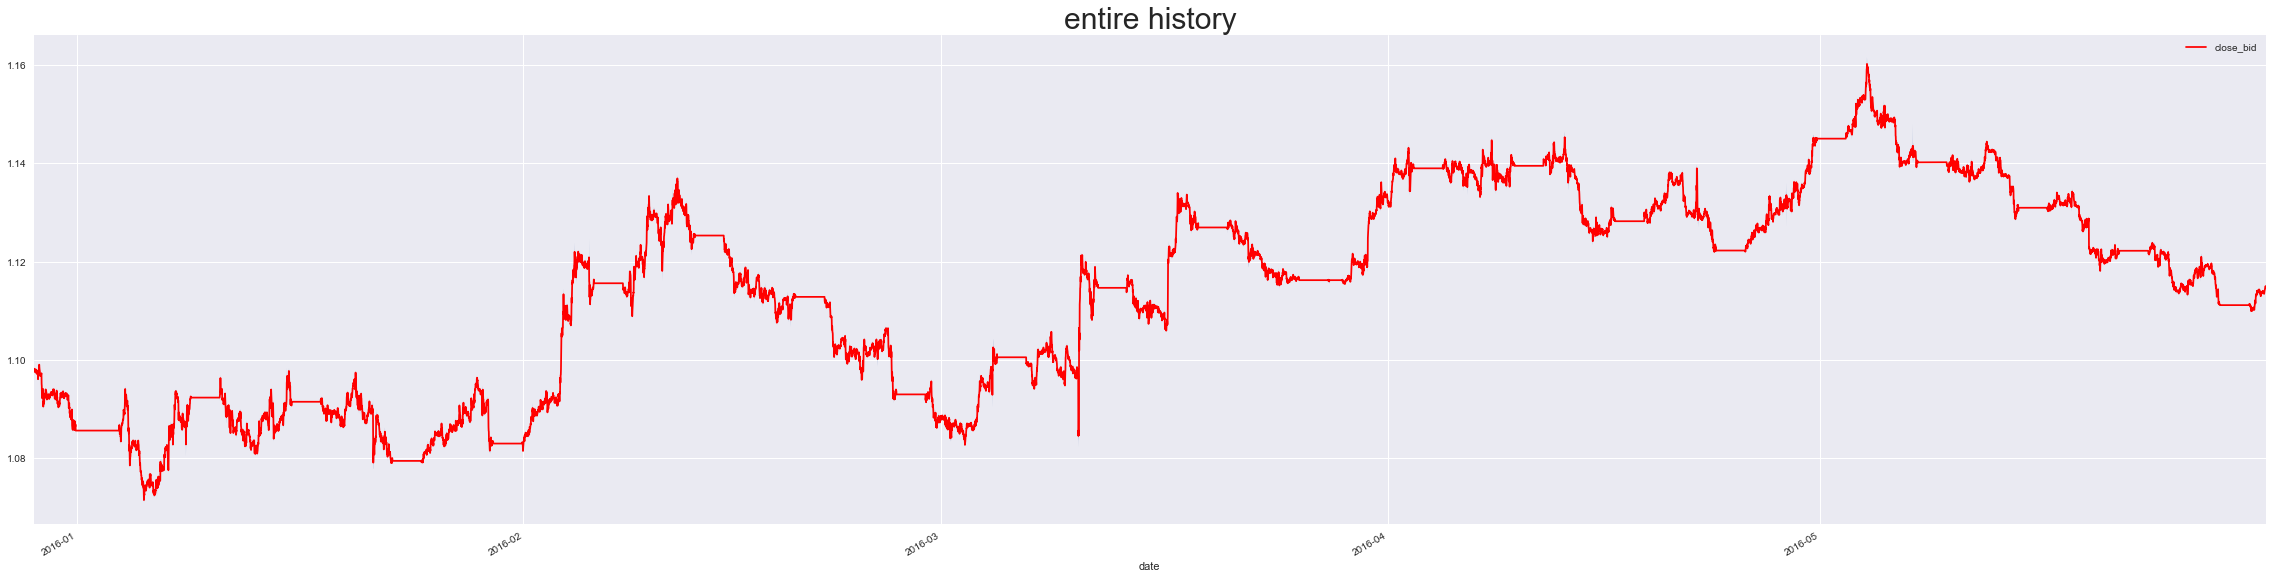

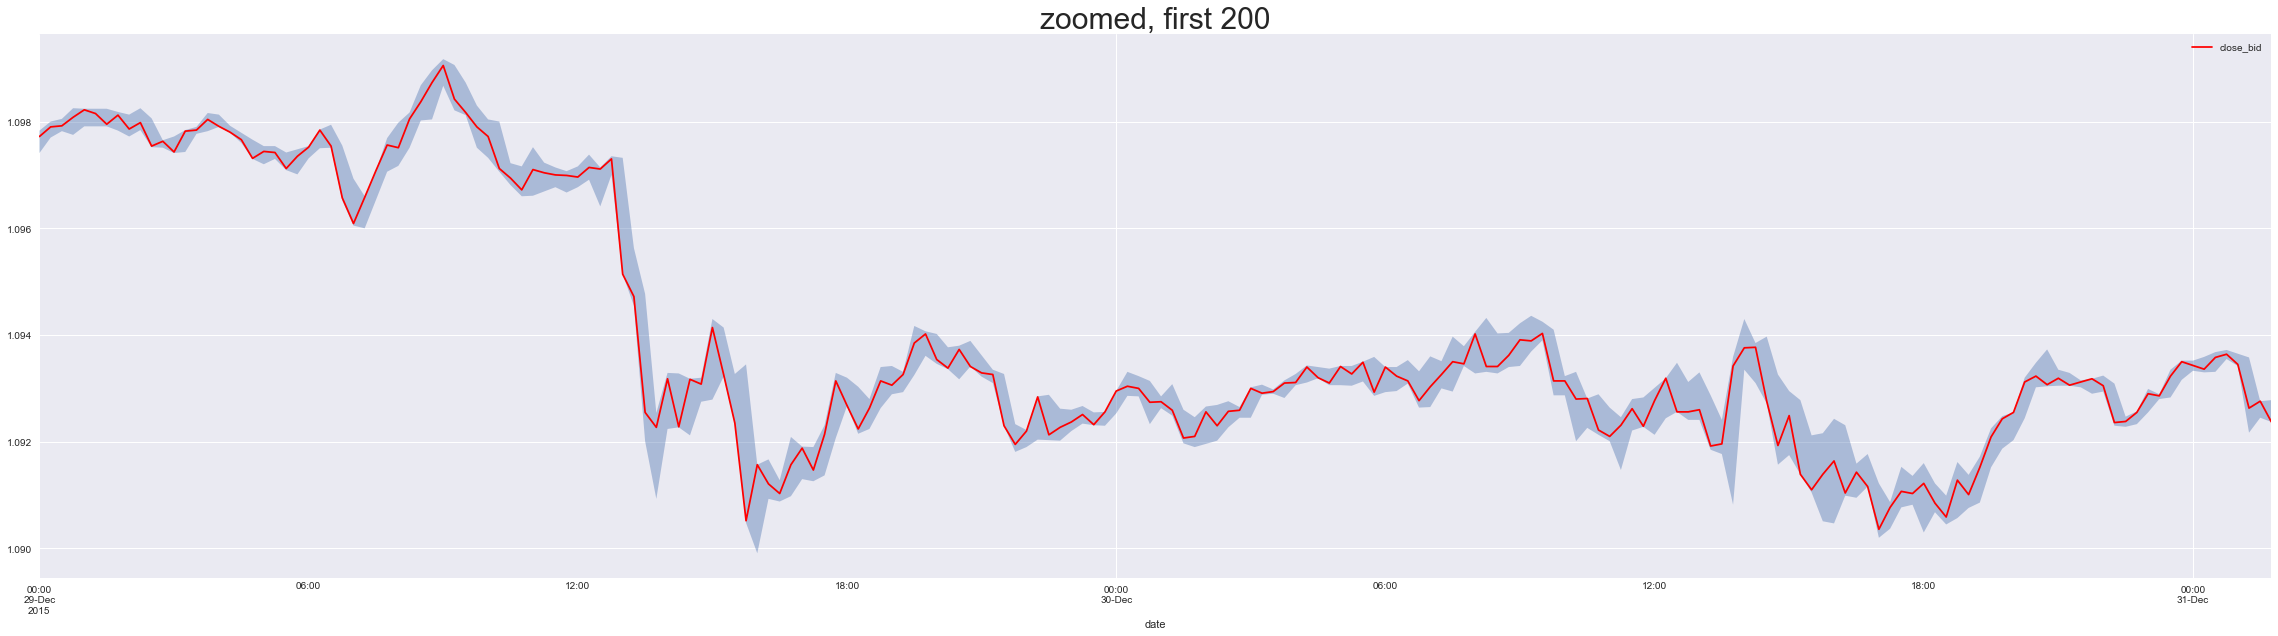

In [22]:
# plot close price, compare to low and high price
ax = df.plot(x=df.index, y='close_bid', c='red', figsize=(40,10))
index = [str(item) for item in df.index]
plt.fill_between(x=index, y1='low_bid',y2='high_bid', data=df, alpha=0.4)
plt.title("entire history", fontsize=30)
plt.show()

# plot first 200 entries 
p = df[:200].copy()
ax = p.plot(x=p.index, y='close_bid', c='red', figsize=(40,10))
index = [str(item) for item in p.index]
plt.fill_between(x=index, y1='low_bid', y2='high_bid', data=p, alpha=0.4)
plt.title('zoomed, first 200', fontsize=30)
plt.show()

In [39]:
# Scale and create datasets
target_index = df.columns.tolist().index('close_bid')
high_index = df.columns.tolist().index('high_bid')
low_index = df.columns.tolist().index('low_bid')
dataset = df.values.astype('float32')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Create y_scaler to inverse it later
y_scaler = MinMaxScaler(feature_range=(0, 1))
t_y = df['close_bid'].values.astype('float32')
t_y = np.reshape(t_y, (-1, 1))
y_scaler = y_scaler.fit(t_y)
    
# Set look_back to 20 which is 5 hours (15min*20)
X, y = create_dataset(dataset, look_back_rows=20)
y = y[:,target_index]

In [40]:
# Set training data size
# We have a large enough dataset. So divid into 98% training / 1%  development / 1% test sets
train_size = int(len(X) * 0.99)
trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense

# create a small LSTM network
model = Sequential()
model.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 20, 20)            2960      
_________________________________________________________________
lstm_10 (LSTM)               (None, 20, 20)            3280      
_________________________________________________________________
lstm_11 (LSTM)               (None, 20, 10)            1240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 10)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 4)                 240       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total para

In [43]:

# Save the best weight during training.
#simname = "15_min_replication_1"
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(simname + ".weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

# Fit
"""
it seems batch size controls convergence speed a lot! Batch size tells how many examples are propagated through the network.
Weights are adjusted based on results with these examples. This is useful if the full dataset takes too much memory
It also speeds up training, as you will converge quicker (dont have to wait for a full iteration of each example to adjust weights).
"""
callbacks_list = [checkpoint]
%time history = model.fit(trainX, trainY, epochs=200, batch_size=500, verbose=0, callbacks=callbacks_list, validation_split=0.1)

Epoch 00000: val_mean_squared_error improved from inf to 0.26399, saving model to bm_kaggle.weights.best.hdf5
Epoch 00001: val_mean_squared_error improved from 0.26399 to 0.17870, saving model to bm_kaggle.weights.best.hdf5
Epoch 00002: val_mean_squared_error improved from 0.17870 to 0.07720, saving model to bm_kaggle.weights.best.hdf5
Epoch 00003: val_mean_squared_error improved from 0.07720 to 0.02238, saving model to bm_kaggle.weights.best.hdf5
Epoch 00004: val_mean_squared_error improved from 0.02238 to 0.01324, saving model to bm_kaggle.weights.best.hdf5
Epoch 00005: val_mean_squared_error did not improve
Epoch 00006: val_mean_squared_error did not improve
Epoch 00007: val_mean_squared_error improved from 0.01324 to 0.01135, saving model to bm_kaggle.weights.best.hdf5
Epoch 00008: val_mean_squared_error improved from 0.01135 to 0.00217, saving model to bm_kaggle.weights.best.hdf5
Epoch 00009: val_mean_squared_error improved from 0.00217 to 0.00062, saving model to bm_kaggle.weight

Epoch 00119: val_mean_squared_error did not improve
Epoch 00120: val_mean_squared_error did not improve
Epoch 00121: val_mean_squared_error did not improve
Epoch 00122: val_mean_squared_error did not improve
Epoch 00123: val_mean_squared_error did not improve
Epoch 00124: val_mean_squared_error did not improve
Epoch 00125: val_mean_squared_error improved from 0.00005 to 0.00005, saving model to bm_kaggle.weights.best.hdf5
Epoch 00126: val_mean_squared_error improved from 0.00005 to 0.00005, saving model to bm_kaggle.weights.best.hdf5
Epoch 00127: val_mean_squared_error did not improve
Epoch 00128: val_mean_squared_error improved from 0.00005 to 0.00004, saving model to bm_kaggle.weights.best.hdf5
Epoch 00129: val_mean_squared_error did not improve
Epoch 00130: val_mean_squared_error did not improve
Epoch 00131: val_mean_squared_error did not improve
Epoch 00132: val_mean_squared_error did not improve
Epoch 00133: val_mean_squared_error did not improve
Epoch 00134: val_mean_squared_erro

epoch 200


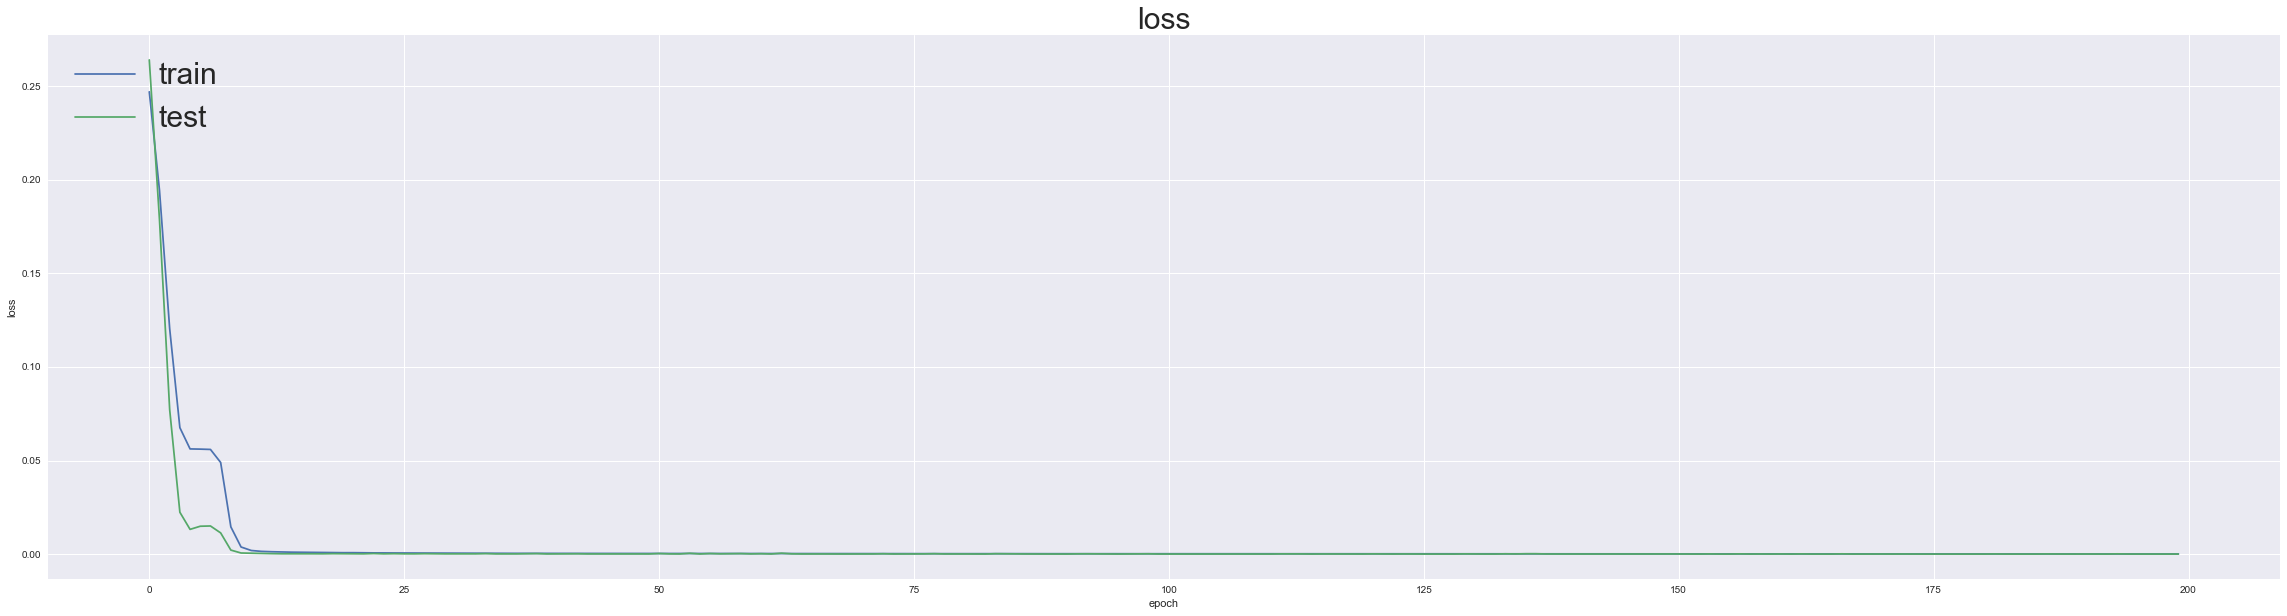

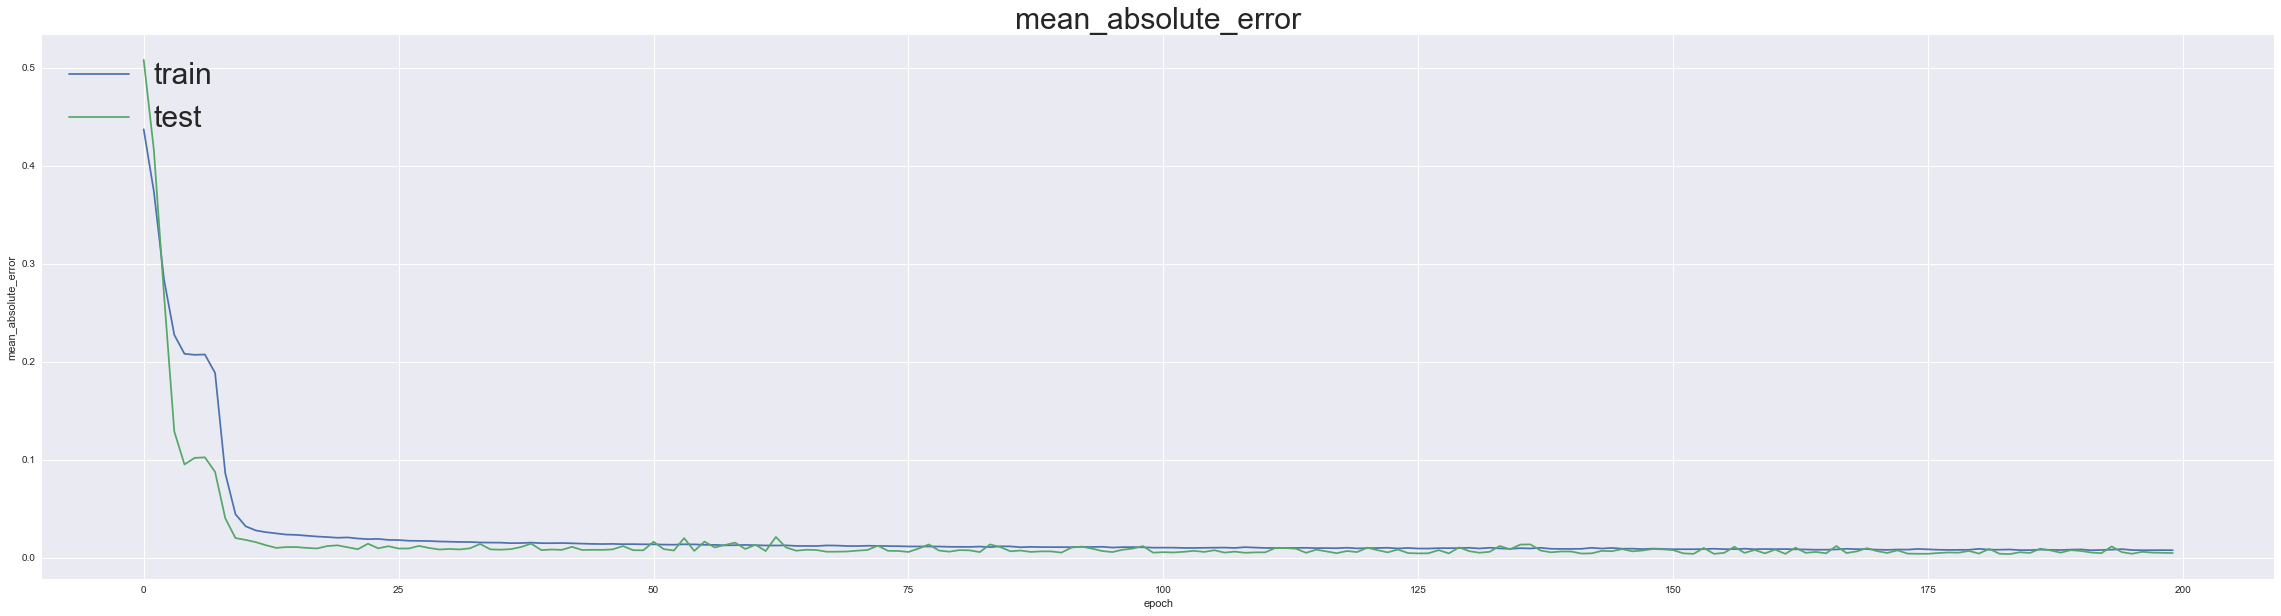

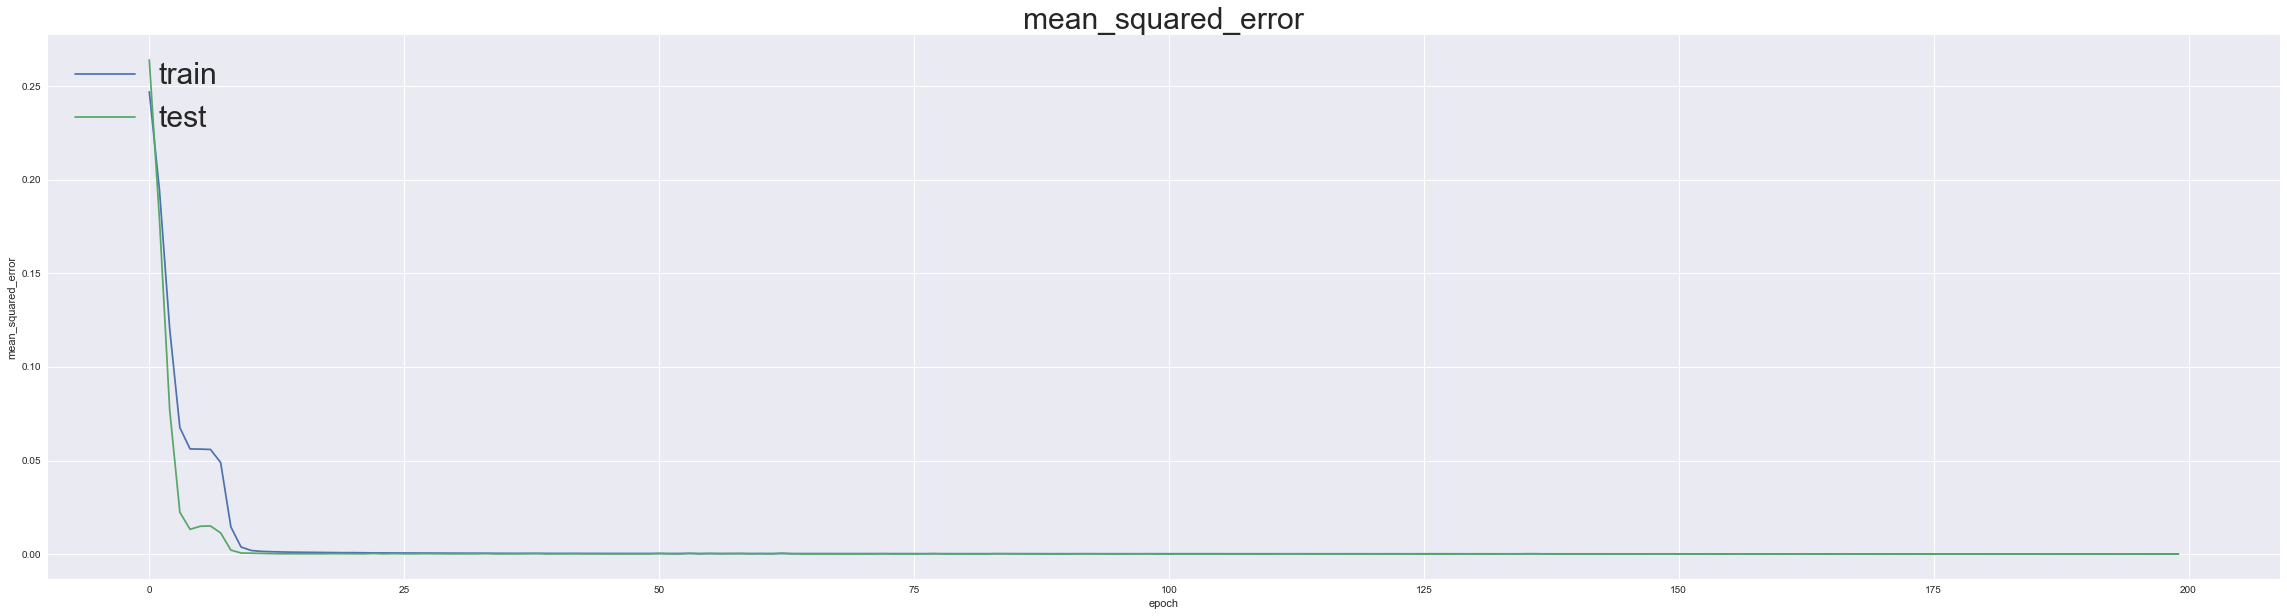

In [44]:
epoch = len(history.history['loss'])
print("epoch", epoch)
for k in list(history.history.keys()):
    if 'val' not in k:
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_' + k])
        plt.title(k, fontsize=30)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left', fontsize=30)
        plt.show()

In [45]:
min(history.history['val_mean_absolute_error'])

0.0034859505006226755

As seen from the above, the model seems to have converged nicely, but the mean absolute error on the development data remains at ~0.003X which means the model is unusable in practice. Ideally, we want to get ~0.0005. Let's go back to the best weight, and decay the learning rate while retraining the model

In [47]:
# tune model by starting from best weights and rerunning with decaying learning rate
# Load the weight that worked the best
model.load_weights(simname+".weights.best.hdf5")
#epoch=60

# Train again with decaying learning rate
from keras.callbacks import LearningRateScheduler
import keras.backend as K

def scheduler(epoch):
    if epoch%2==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)
lr_decay = LearningRateScheduler(scheduler) # do sth to learning rate

callbacks_list = [checkpoint, lr_decay] # checkin with these once in a while
history = model.fit(trainX, trainY, epochs=int(epoch/3), batch_size=500, verbose=0, callbacks=callbacks_list, validation_split=0.1)

Epoch 00000: val_mean_squared_error did not improve
Epoch 00001: val_mean_squared_error did not improve
lr changed to 0.0005904900433961303
Epoch 00002: val_mean_squared_error did not improve
Epoch 00003: val_mean_squared_error did not improve
lr changed to 0.0005314410547725857
Epoch 00004: val_mean_squared_error did not improve
Epoch 00005: val_mean_squared_error did not improve
lr changed to 0.00047829695977270604
Epoch 00006: val_mean_squared_error did not improve
Epoch 00007: val_mean_squared_error did not improve
lr changed to 0.0004304672533180565
Epoch 00008: val_mean_squared_error did not improve
Epoch 00009: val_mean_squared_error did not improve
lr changed to 0.00038742052274756136
Epoch 00010: val_mean_squared_error did not improve
Epoch 00011: val_mean_squared_error did not improve
lr changed to 0.0003486784757114947
Epoch 00012: val_mean_squared_error did not improve
Epoch 00013: val_mean_squared_error did not improve
lr changed to 0.00031381062290165574
Epoch 00014: val_

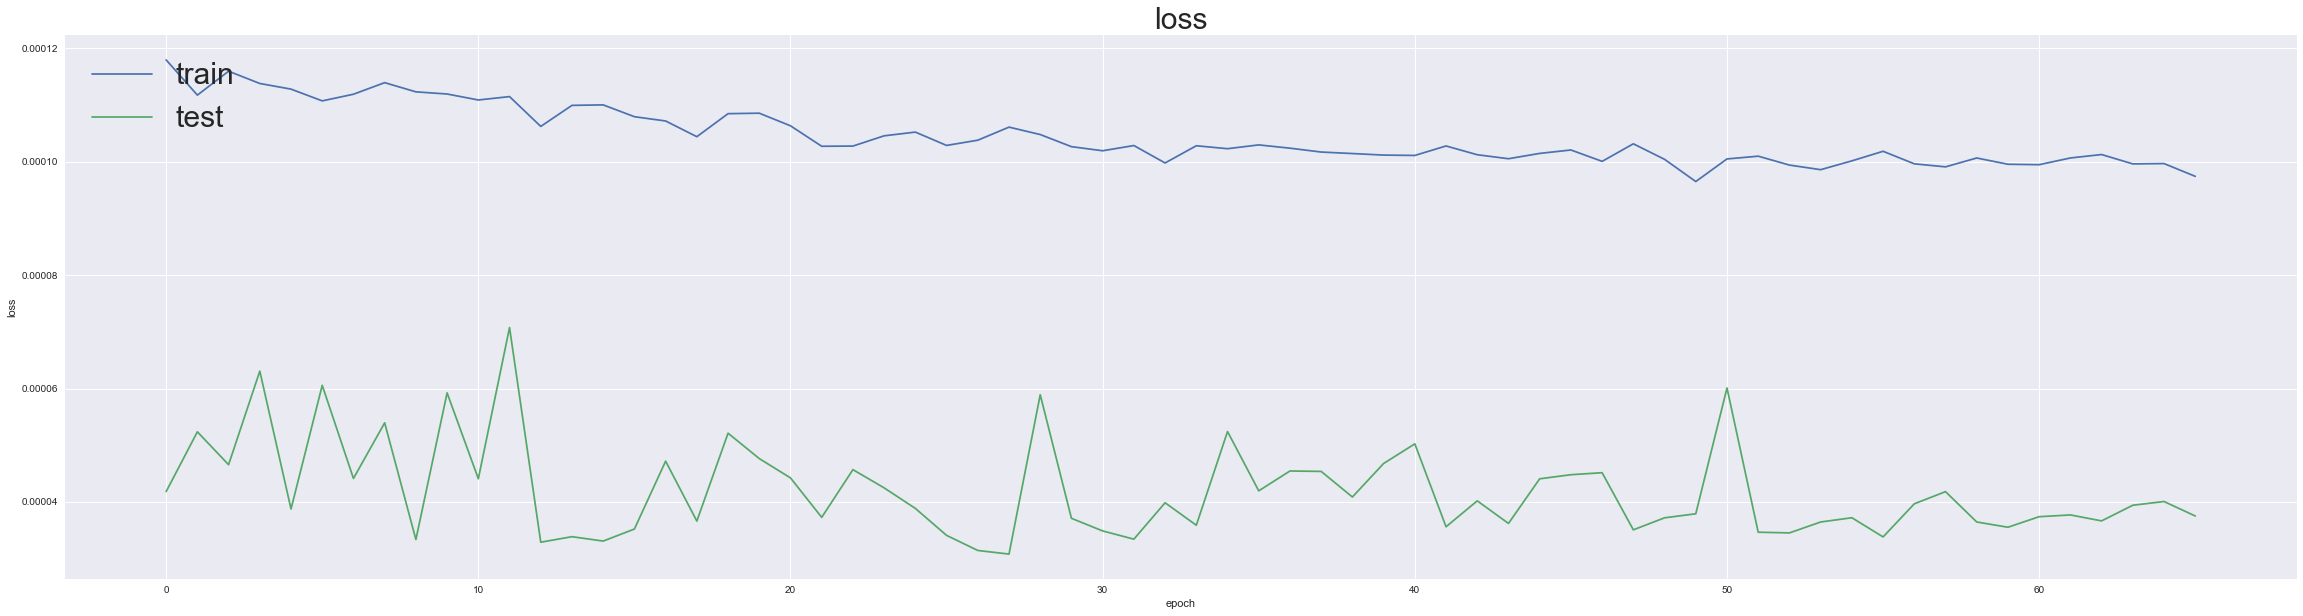

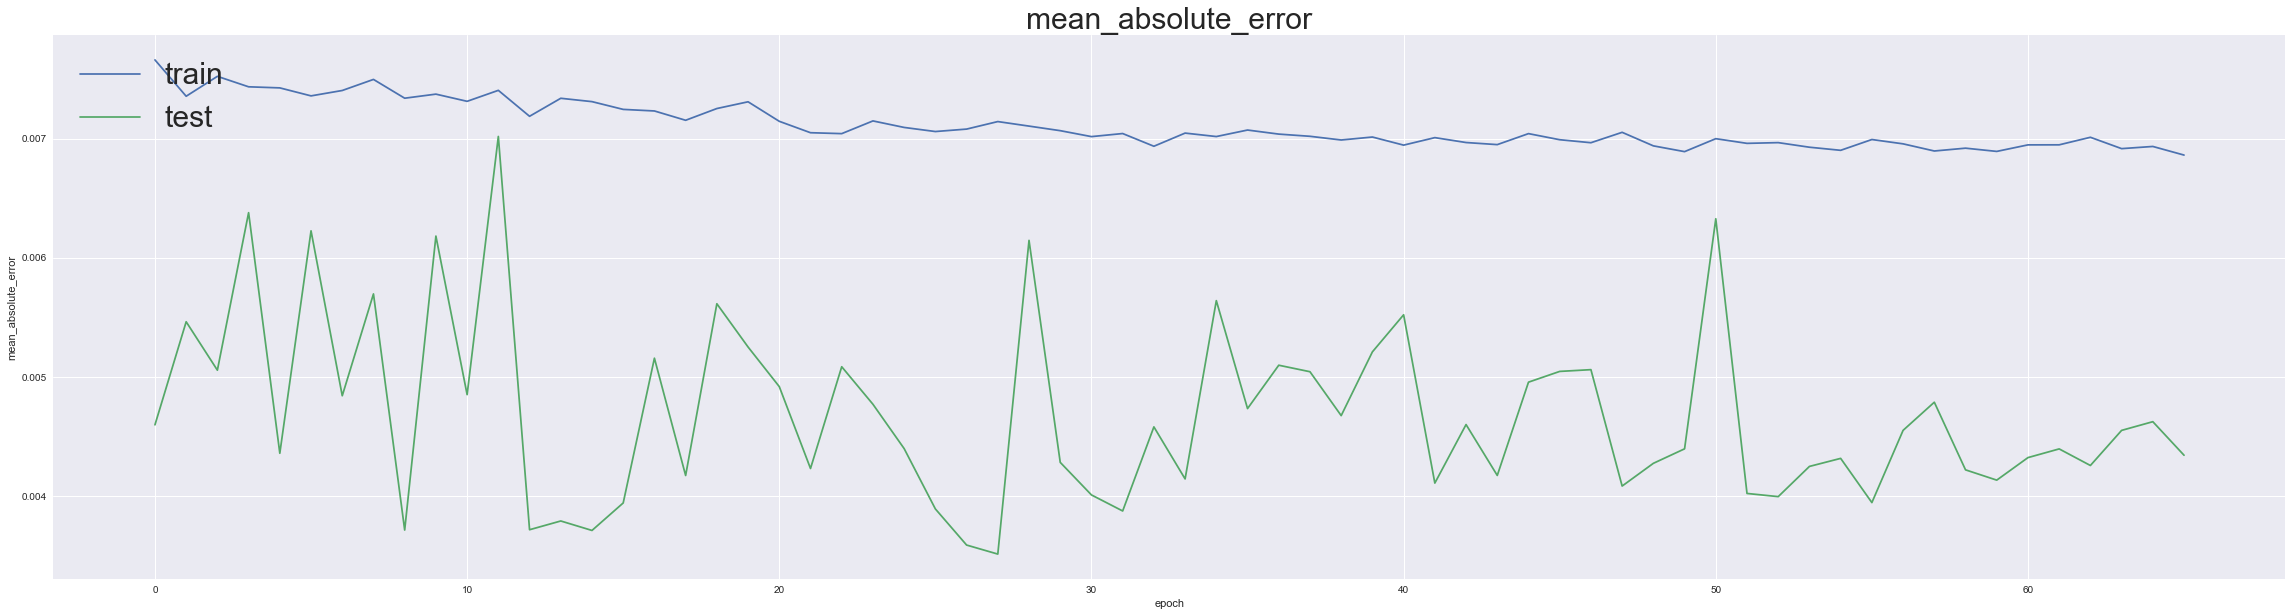

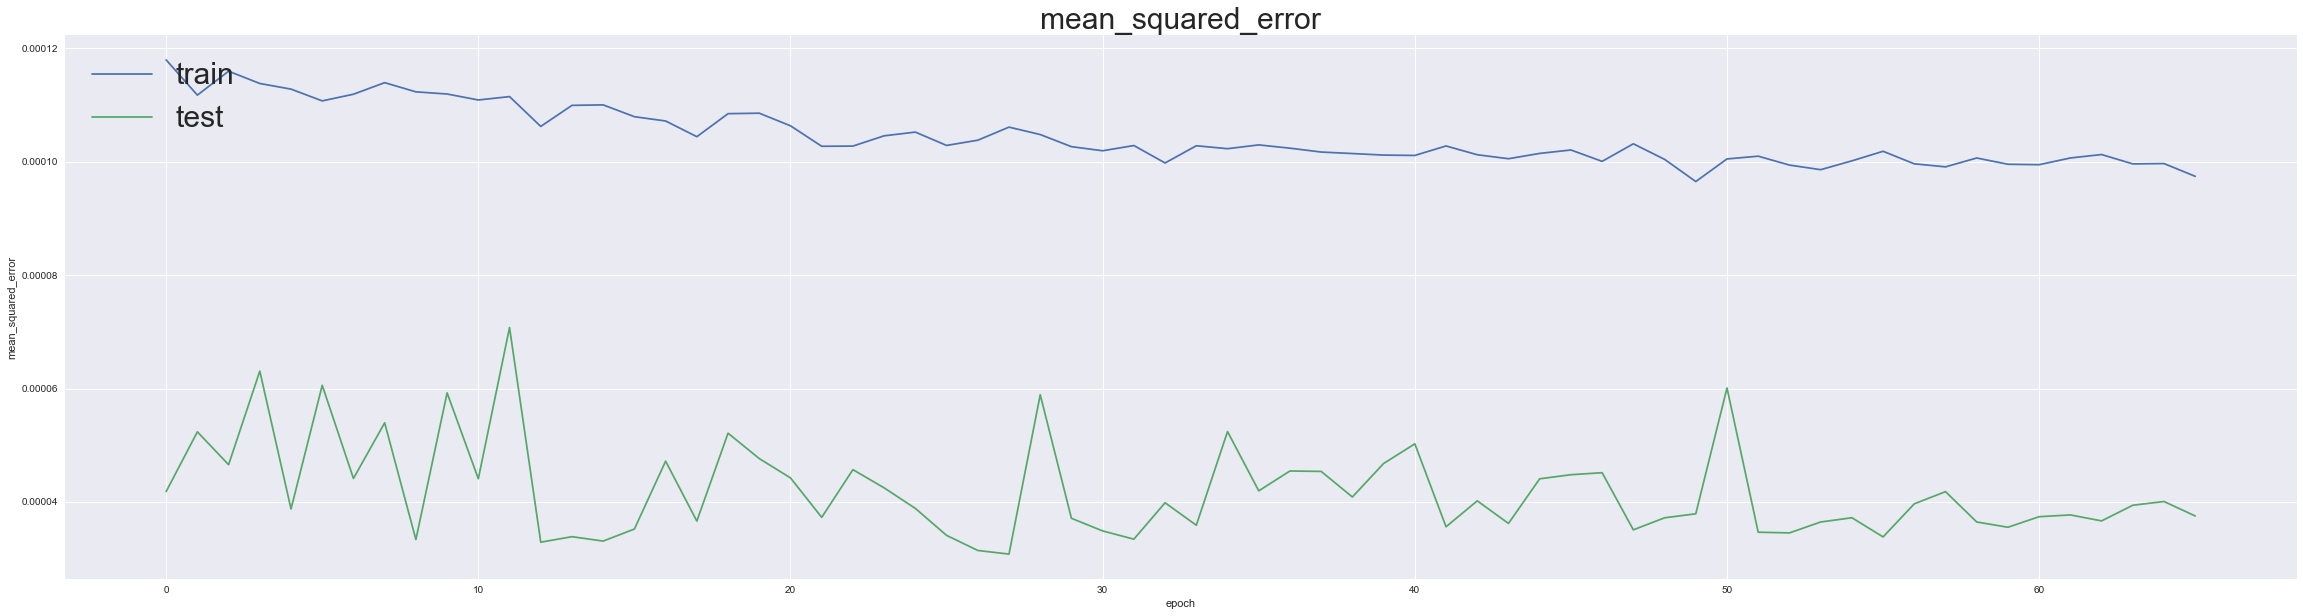

In [48]:
epoch = len(history.history['loss']) # get epoch length from any of the columns
for k in list(history.history.keys()):
    if 'val' not in k:
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k]) # this is for train
        plt.plot(history.history['val_' + k]) # this is for test
        plt.title(k, fontsize=30)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left', fontsize=30)
        plt.show()


In [49]:
min(history.history['val_mean_absolute_error'])


0.0035122722055874436

The variance should have improved slightly. However, unless the mean absolute error is not small enough. The model is still not an usable model in practice. This is mainly due to only using the sample data for training and limiting epoch to a few hundreds.


# Visually compare the delta between the prediction and actual (scaled values)

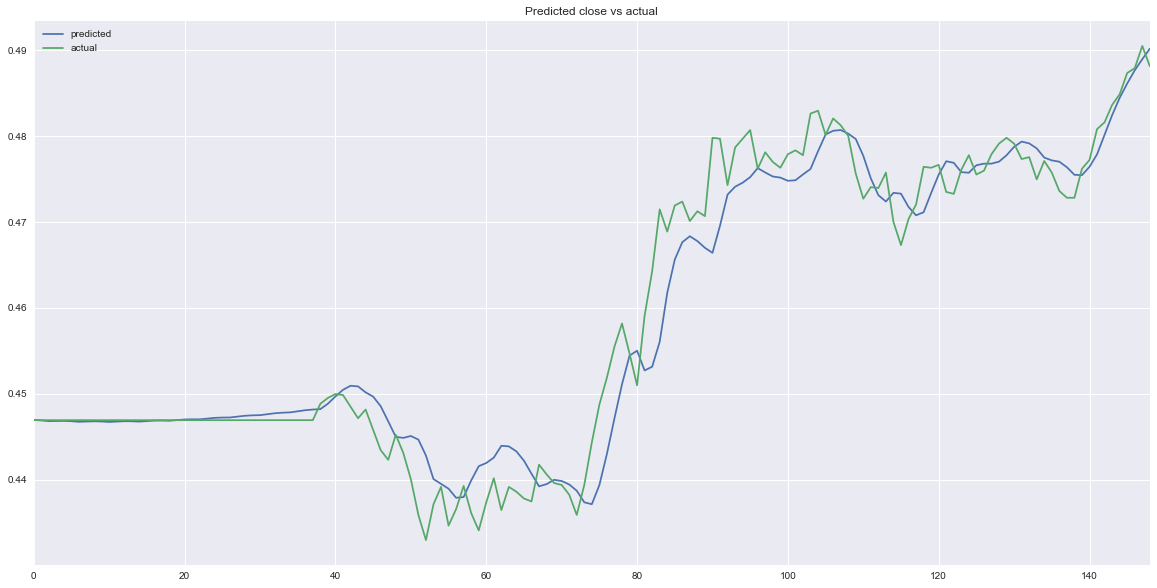

c:\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


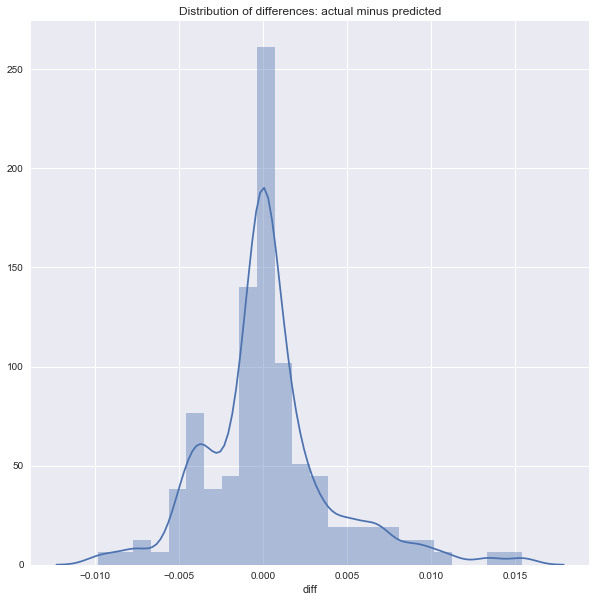

MSE :  1.47740581385e-05
MAE :  0.00256412901334


count    149.000000
mean       0.000289
std        0.003846
min       -0.009856
25%       -0.001409
50%        0.000065
75%        0.001438
max        0.015438
Name: diff, dtype: float64

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Benchmark
model.load_weights(simname+".weights.best.hdf5")

pred = model.predict(testX) # predict on testset

predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['actual'] = testY
predictions = predictions.astype(float)

predictions.plot(figsize=(20,10))
plt.title("Predicted close vs actual")
plt.show()

predictions['diff'] = predictions['actual'] - predictions['predicted']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences: actual minus predicted')
plt.show()
# if predicted minus actual is positive, this is 

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values))
predictions['diff'].describe()

# Compare the unscaled values and see if the prediction falls within the Low and High


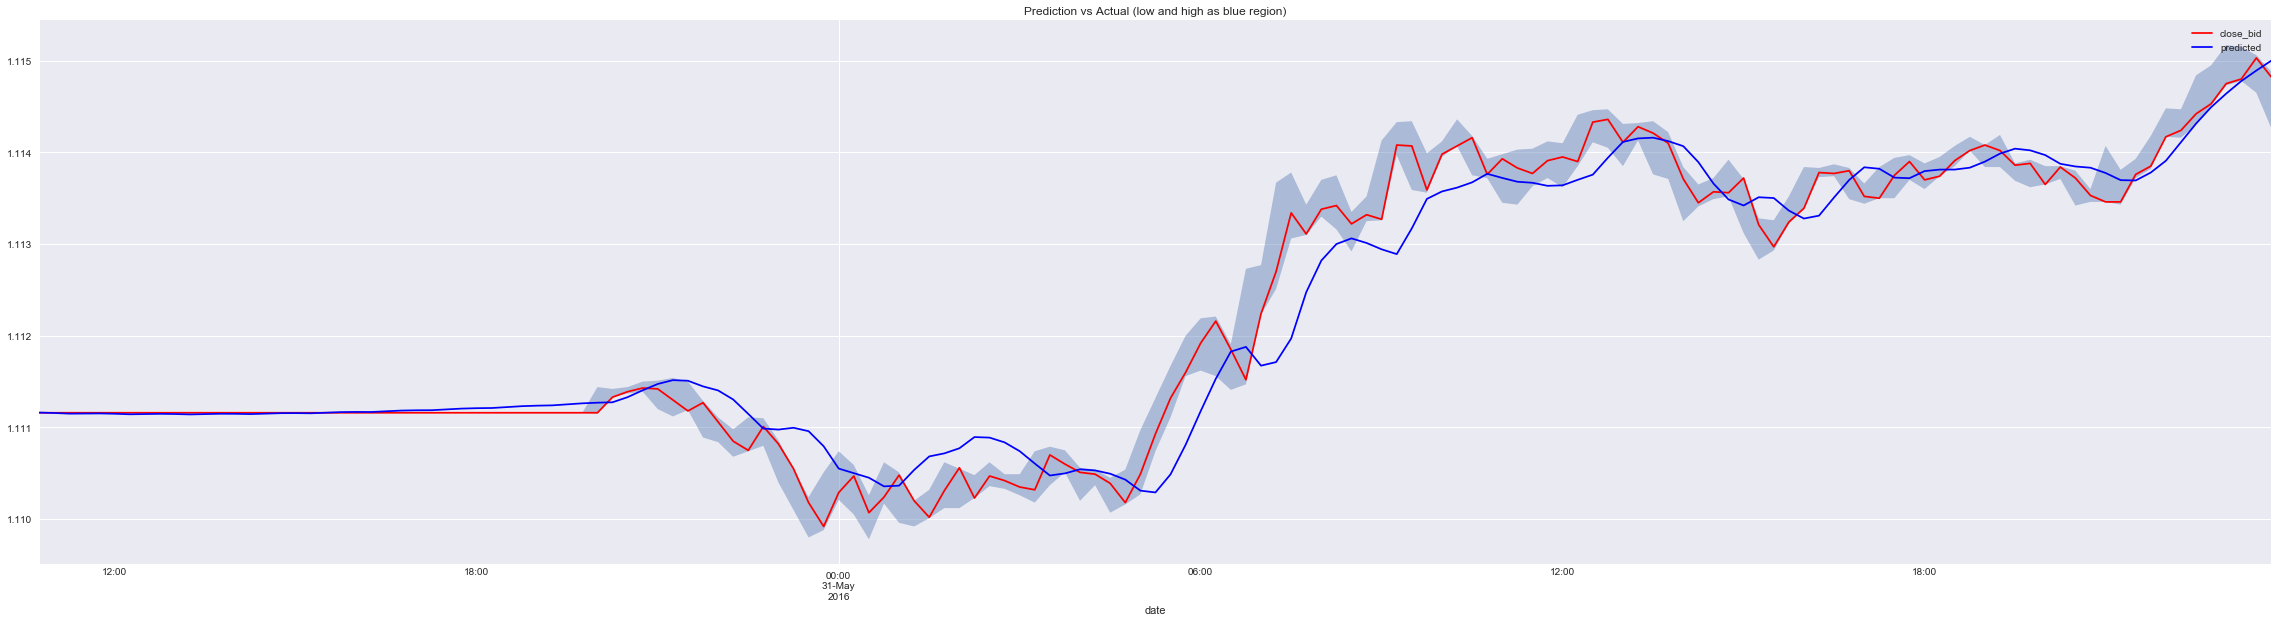

c:\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


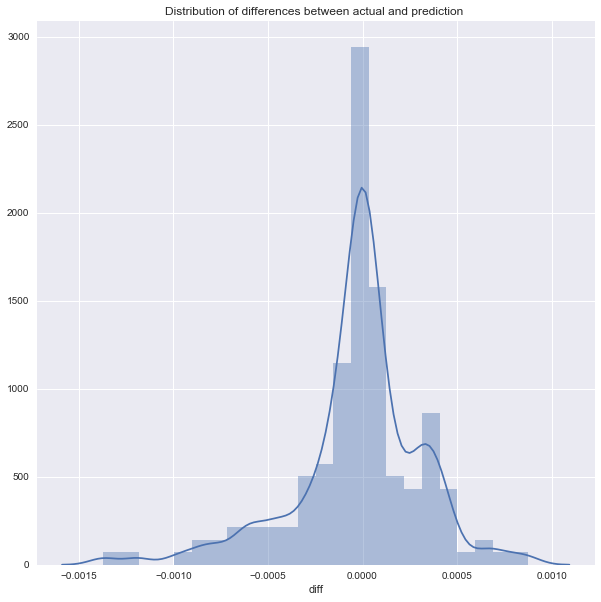

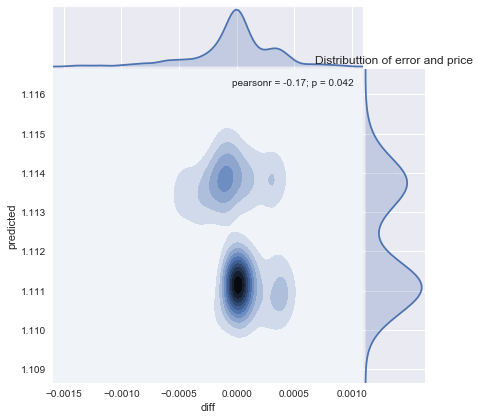

MSE :  1.16343369599e-07
MAE :  0.000227541731508


count    149.000000
mean      -0.000026
std        0.000341
min       -0.001370
25%       -0.000128
50%       -0.000006
75%        0.000125
max        0.000875
Name: diff, dtype: float64

In [51]:
pred = model.predict(testX)
pred = y_scaler.inverse_transform(pred)
close = y_scaler.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))
predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['close_bid'] = pd.Series(np.reshape(close, (close.shape[0])))

p = df[-pred.shape[0]:].copy()
predictions.index = p.index
predictions = predictions.astype(float)
predictions = predictions.merge(p[['low_bid', 'high_bid']], right_index=True, left_index=True)

ax = predictions.plot(x=predictions.index, y='close_bid', c='red', figsize=(40,10))
ax = predictions.plot(x=predictions.index, y='predicted', c='blue', figsize=(40,10), ax=ax)
index = [str(item) for item in predictions.index]
plt.fill_between(x=index, y1='low_bid', y2='high_bid', data=p, alpha=0.4)
plt.title('Prediction vs Actual (low and high as blue region)')
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['close_bid']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction ')
plt.show()

g = sns.jointplot("diff", "predicted", data=predictions, kind="kde", space=0)
plt.title('Distributtion of error and price')
plt.show()

# predictions['correct'] = (predictions['predicted'] <= predictions['high']) & (predictions['predicted'] >= predictions['low'])
# sns.factorplot(data=predictions, x='correct', kind='count')

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['close_bid'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['close_bid'].values))
predictions['diff'].describe()


so it looks i improved on the previous results, by using lookback of 1 tick, 100 iterations, and my additional features. However, can i predict fast enough to make trading decisions?

Sim results:

- it got a lot worse when i changed lookback to 20 ticks